In [7]:
#add averaging script paths
import sys
sys.path.append('../PythonCode/scripts')

import fl_algorithms as fla

#imports
import numpy as np
from matplotlib import pyplot as plt
from sklearn.manifold import MDS

In [24]:
def generate_flag_data_outliers(n_inliers: int, n: int, n_outliers: int, 
                                flag_type: list, seed: int = 2) -> list:
    '''
    Generate data on the flag manifold with a percentage of outliers.

    Inputs:
        n_inliers: number of inliers
        n: dimension of ambient space
        n_outliers: number of outliers
        flag_type: type of flag
        seed: reproducibility

    Outputs:
        list of flags
    '''

    np.random.seed(seed)

    k = flag_type[-1]
    center_pt = np.linalg.qr(np.random.rand(n, k)-.5)[0][:,:k]

    data = []
    for _ in range(n_inliers):
        rand_mat = center_pt + 0.1*(np.random.rand(n, k)-.5)
        data.append(np.linalg.qr(rand_mat)[0][:,:k])
    for _ in range(n_outliers):
        rand_mat = center_pt + (np.random.rand(n, k)-.5)
        data.append(np.linalg.qr(rand_mat)[0][:,:k])

    return data, center_pt

def chordal_dist_mat(data: list, flag_type: list) -> np.array:
    '''
    chordal distance matrix between data

    Inputs:
        data: a list of flags
        flag_type: the type of flags

    Output:
        distance matrix
    
    '''

    n_pts = len(data)

    distances = np.zeros((n_pts, n_pts))
    for i in range(n_pts):
        for j in range(i+1, n_pts, 1):
            distances[i,j] = fla.chordal_dist(data[i], data[j], flag_type = flag_type)
            distances[j,i] = distances[i,j].copy()
    return distances

In [25]:

n = 6 #ambient vector space dimension
flag_type = [1,3,5] #type of flag

n_its = 10 #number of iterations

n_inliers = 20 #number of inlier data points
n_outliers = 10 #number of oulier  data points
n_pts = n_inliers+n_outliers

data, center_pt = generate_flag_data_outliers(n_inliers,
                                              n, 
                                              n_outliers, 
                                              flag_type,
                                              seed = 3)

#stack data into n x k x p data matrix
stacked_data = np.stack(data, axis = 2)

#initial point for averaging algorithm
k = flag_type[-1]
init_pt = np.eye(n)[:,:k]

In [26]:
chordal_flag_mean = fla.flag_mean(stacked_data,  
                                  flag_type = flag_type, 
                                  initial_point = init_pt,
                                  return_all = False)

chordal_flag_median = fla.flag_median(stacked_data,  
                                      flag_type = flag_type, 
                                      initial_point_median = init_pt) 

In [27]:
#distance matrix and MDS
all_data = data + [chordal_flag_mean] + [chordal_flag_median]

D = chordal_dist_mat(all_data, flag_type)

embedding = MDS(n_components=2, dissimilarity='precomputed')
embedded_data = embedding.fit_transform(D)

/Users/natemankovich/Library/Python/3.8/lib/python/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Text(0, 0.5, 'MDS 2')

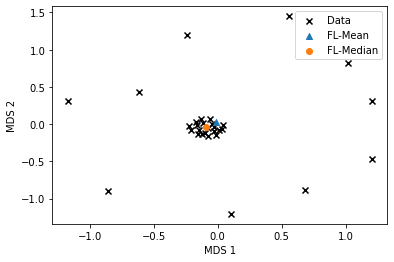

In [29]:
#plot the result
plt.scatter(embedded_data[:n_pts,0], embedded_data[:n_pts,1],  color = 'k', marker = 'x', label = 'Data')
plt.scatter(embedded_data[n_pts:n_pts+1,0], embedded_data[n_pts:n_pts+1,1], marker = '^',label = 'FL-Mean')
plt.scatter(embedded_data[n_pts+1:n_pts+2,0], embedded_data[n_pts+1:n_pts+2,1],label = 'FL-Median')
plt.legend()
plt.xlabel('MDS 1')
plt.ylabel('MDS 2')